In [3]:
import pickle
import h5py
import numpy as np
pkl_file = '1_D_Fracture/fracture_results_0407/global_sensitivity_results_3.69e+06_0407.pkl'
with open(pkl_file, 'rb') as f:
    data = pickle.load(f)

#save data as a pandas dataframe
import pandas as pd
df = pd.DataFrame(data)

FileNotFoundError: [Errno 2] No such file or directory: '1_D_Fracture/fracture_results_0407/global_sensitivity_results_3.69e+06_0407.pkl'

In [36]:
print(df.columns)
print(df['Aluminum Alloy'].keys())

Index(['Aluminum Alloy', 'Titanium Alloy', 'CFRP', 'Stainless Steel',
       'Beryllium', 'Glass', 'Copper Alloy'],
      dtype='object')
Index(['E_samples', 'Gc_samples', 'strength_samples', 'density_samples',
       'num_frag', 'avg_frag', 'time', 'stress', 'velocity', 'damage',
       'COD_MAX', 'frag_sizes', 'strain_rate'],
      dtype='object')


In [3]:
import pickle
import h5py
import numpy as np

def convert_pkl_to_h5(pkl_path, h5_path):
    """
    Convert a global_results pickle (per-material dict of simulation outputs)
    into an HDF5 file with chunked, compressed datasets.
    """
    # Load pickle
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    with h5py.File(h5_path, 'w') as hf:
        for material, mat in data.items():
            grp = hf.create_group(material)
            N_sim = len(mat['E_samples'])
            
            # 1) Parameter samples (shape: N_sim,)
            for param in ['E_samples', 'Gc_samples', 'strength_samples', 'density_samples',
                          'num_frag', 'avg_frag']:
                arr = np.array(mat[param], dtype=np.float32)
                grp.create_dataset(param, data=arr,
                                   compression='gzip', chunks=(min(64, N_sim),))
            
            # 2) Time snapshots (list of arrays)
            time_list = mat['time']
            max_t = max(arr.shape[0] for arr in time_list)
            t_arr = np.zeros((N_sim, max_t), dtype=np.float32)
            t_len = np.zeros(N_sim, dtype=np.int32)
            for i, arr in enumerate(time_list):
                l = arr.shape[0]
                t_len[i] = l
                t_arr[i, :l] = arr
            grp.create_dataset('time', data=t_arr,
                               compression='gzip', chunks=(1, min(max_t, 10)))
            grp.create_dataset('time_lengths', data=t_len,
                               compression='gzip', chunks=(min(64, N_sim),))
            
            # Spatial size inferred from stress arrays
            stress0 = mat['stress'][0]
            N_space = stress0.shape[1]
            
            # 3) Field snapshots
            for field in ['stress', 'velocity', 'damage', 'COD_MAX']:
                fld_list = mat[field]
                max_nt = max(arr.shape[0] for arr in fld_list)
                f_arr = np.zeros((N_sim, max_nt, N_space), dtype=np.float32)
                f_len = np.zeros(N_sim, dtype=np.int32)
                for i, arr in enumerate(fld_list):
                    nt_i = arr.shape[0]
                    f_len[i] = nt_i
                    f_arr[i, :nt_i, :] = arr
                grp.create_dataset(field, data=f_arr,
                                   compression='gzip',
                                   chunks=(1, min(max_nt, 10), min(N_space, 1024)))
                grp.create_dataset(f'{field}_lengths', data=f_len,
                                   compression='gzip', chunks=(min(64, N_sim),))
            
            # 4) Fragment size distributions
            frag_list = mat['frag_sizes']
            max_fs = max(arr.shape[0] for arr in frag_list)
            fs_arr = np.zeros((N_sim, max_fs), dtype=np.float32)
            fs_len = np.zeros(N_sim, dtype=np.int32)
            for i, arr in enumerate(frag_list):
                ln = arr.shape[0]
                fs_len[i] = ln
                fs_arr[i, :ln] = arr
            grp.create_dataset('frag_sizes', data=fs_arr,
                               compression='gzip', chunks=(1, min(max_fs, 512)))
            grp.create_dataset('frag_sizes_lengths', data=fs_len,
                               compression='gzip', chunks=(min(64, N_sim),))
            
            # 5) Strain rate (scalar)
            grp.attrs['strain_rate'] = float(mat['strain_rate'])
    
    print(f"Converted '{pkl_path}' to '{h5_path}' successfully.")

import os
import glob
# pkl_files = glob.glob('1D_Fracture_Sim_Results_pkl/global_sensitivity_results_*.pkl')
# h5_files = [f.replace('.pkl', '.h5') for f in pkl_files]
# for i in range(len(pkl_files)):
#     pkl_file = pkl_files[i]
#     h5_file = h5_files[i]
#     print(f"Converting {pkl_file} to {h5_file}")
#     convert_pkl_to_h5(pkl_file, h5_file)
pkl_file = '1D_Fracture_Sim_Results_pkl/global_sensitivity_results_1.00e+04_0407.pkl'
h5_file = '1D_Fracture_Sim_Results_h5/global_sensitivity_results_1.00e+04_0407.h5'
convert_pkl_to_h5(pkl_file, h5_file)

Converted '1D_Fracture_Sim_Results_pkl/global_sensitivity_results_1.00e+04_0407.pkl' to '1D_Fracture_Sim_Results_h5/global_sensitivity_results_1.00e+04_0407.h5' successfully.


In [5]:
import h5py

h5_path = '1_D_Fracture/fracture_results_h5/global_sensitivity_results_3.69e+06_0407.h5'  # Update to your actual HDF5 file path

with h5py.File(h5_path, 'r') as hf:
    print("Top-level keys (materials):")
    for key in hf.keys():
        print(" -", key)
    print("\nContents of each material group:")
    for material in hf.keys():
        grp = hf[material]
        print(f"\nMaterial group: {material}")
        for dset_name, dset in grp.items():
            # Only print datasets, skip groups if any
            if isinstance(dset, h5py.Dataset):
                print(f"  Dataset: {dset_name} | shape: {dset.shape} | dtype: {dset.dtype}")
                #print damage
                # if dset_name == 'time':
                #     print(f"  Time data: {dset[:][4]}")  # Print the time data}")
                #     print(f"  Time lengths: {grp['time_lengths'][:]}")  # Print the time lengths
                # print("frag_sizes_lengths", grp['frag_sizes_lengths'][:])
                #     print("frag_sizes", grp['frag_sizes'][:])
            else:
                print(f"  Group:   {dset_name}")



Top-level keys (materials):
 - Aluminum Alloy
 - Beryllium
 - CFRP
 - Copper Alloy
 - Glass
 - Stainless Steel
 - Titanium Alloy

Contents of each material group:

Material group: Aluminum Alloy
  Dataset: COD_MAX | shape: (100, 37, 50000) | dtype: float32
  Dataset: COD_MAX_lengths | shape: (100,) | dtype: int32
  Dataset: E_samples | shape: (100,) | dtype: float32
  Dataset: Gc_samples | shape: (100,) | dtype: float32
  Dataset: avg_frag | shape: (100,) | dtype: float32
  Dataset: damage | shape: (100, 37, 50000) | dtype: float32
  Dataset: damage_lengths | shape: (100,) | dtype: int32
  Dataset: density_samples | shape: (100,) | dtype: float32
  Dataset: frag_sizes | shape: (100, 1680) | dtype: float32
  Dataset: frag_sizes_lengths | shape: (100,) | dtype: int32
  Dataset: num_frag | shape: (100,) | dtype: float32
  Dataset: strength_samples | shape: (100,) | dtype: float32
  Dataset: stress | shape: (100, 37, 50000) | dtype: float32
  Dataset: stress_lengths | shape: (100,) | dtype

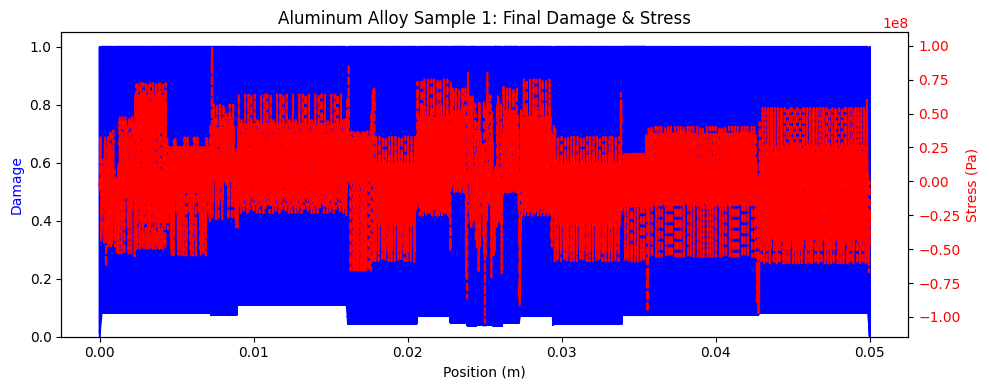

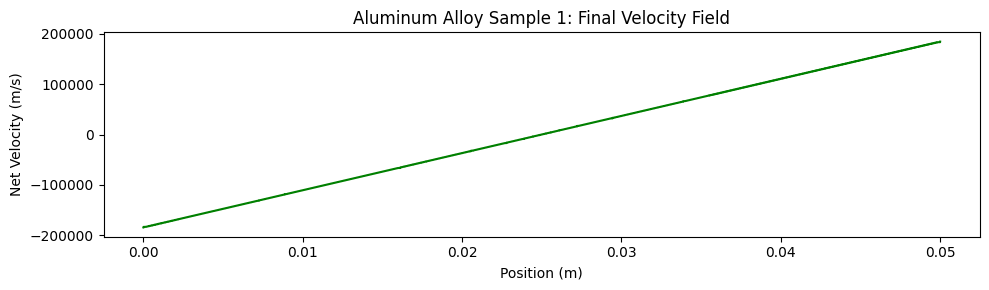

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_sample(h5_path, material, sample_idx, L=0.05):
    """
    Visualize the final damage, stress, and velocity fields for a given
    material and sample index, using uniform X over [0, L].
    """
    with h5py.File(h5_path, 'r') as hf:
        grp = hf[material]
        N_space = grp['damage'].shape[2]
        # Reconstruct spatial coordinates
        X = np.linspace(0, L, N_space)

        # Damage
        d_ds = grp['damage']
        d_len = grp['damage_lengths'][sample_idx]
        damage_final = d_ds[sample_idx, d_len-1, :]

        # Stress
        s_ds = grp['stress']
        s_len = grp['stress_lengths'][sample_idx]
        stress_final = s_ds[sample_idx, s_len-1, :]

        # Velocity
        v_ds = grp['velocity']
        v_len = grp['velocity_lengths'][sample_idx]
        velocity_final = v_ds[sample_idx, v_len-1, :]

    # Plot on single axes with twin y-axis
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()
    ax1.plot(X, damage_final, 'b-', label='Damage')
    ax1.set_ylabel('Damage', color='b')
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel('Position (m)')
    ax2.plot(X, stress_final, 'r--', label='Stress')
    ax2.set_ylabel('Stress (Pa)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax1.set_title(f'{material} Sample {sample_idx}: Final Damage & Stress')
    fig.tight_layout()
    plt.show()

    # Separate velocity plot
    plt.figure(figsize=(10, 3))
    plt.plot(X, velocity_final, 'g-')
    plt.xlabel('Position (m)')
    plt.ylabel('Net Velocity (m/s)')
    plt.title(f'{material} Sample {sample_idx}: Final Velocity Field')
    plt.tight_layout()
    plt.show()

# Example usage:
h5_path = '1_D_Fracture/fracture_results_h5/global_sensitivity_results_3.69e+06_0407.h5'
visualize_sample(h5_path, material='Aluminum Alloy', sample_idx=1, L=0.05)


Saved GIF to fracture_anim_1e6.gif


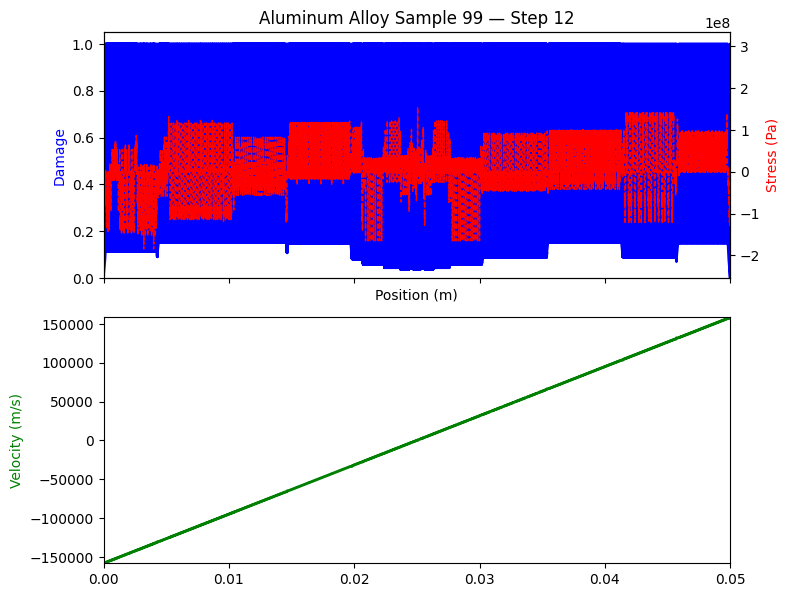

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def animate_sample_from_h5(h5_path, material, sample_idx,
                           L=0.05, fps=5, save_gif=None):
    """
    Animate damage, stress, and velocity fields over time for one sample,
    reading from an HDF5 file structured with:
      - damage        : (N_sim, max_nt, N_space)
      - damage_lengths: (N_sim,)
      - stress        : (N_sim, max_nt, N_space)
      - stress_lengths: (N_sim,)
      - velocity      : (N_sim, max_nt, N_space)
      - velocity_lengths: (N_sim,)
    and per‐group attribute 'strain_rate' (unused here).
    """

    # --- 1) Load and unpad the time‐series for this sample ---
    with h5py.File(h5_path, 'r') as hf:
        grp = hf[material]

        # lengths
        d_len = int(grp['damage_lengths'][sample_idx])
        s_len = int(grp['stress_lengths'][sample_idx])
        v_len = int(grp['velocity_lengths'][sample_idx])

        # padded arrays
        damage_all  = grp['damage'][sample_idx, :d_len, :]
        stress_all  = grp['stress'][sample_idx, :s_len, :]
        velocity_all= grp['velocity'][sample_idx, :v_len, :]

    # We must pick a single time axis length. We'll animate up to the shortest series:
    N_time = min(damage_all.shape[0], stress_all.shape[0], velocity_all.shape[0])
    damage_ts  = damage_all[:N_time]
    stress_ts  = stress_all[:N_time]
    velocity_ts= velocity_all[:N_time]

    N_space = damage_ts.shape[1]
    X = np.linspace(0, L, N_space)

    # --- 2) Set up the figure ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
    ax1_twin = ax1.twinx()

    line_d, = ax1.plot([], [], 'b-', lw=2, label='Damage')
    line_s, = ax1_twin.plot([], [], 'r--', lw=1, label='Stress')
    line_v, = ax2.plot([], [], 'g-', lw=2, label='Velocity')

    ax1.set_ylabel('Damage', color='b')
    ax1.set_ylim(0, 1.05)
    ax1_twin.set_ylabel('Stress (Pa)', color='r')
    ax1_twin.set_ylim(np.min(stress_ts), np.max(stress_ts))
    ax1.set_xlim(0, L)
    ax1.set_xlabel('Position (m)')
    ax2.set_ylabel('Velocity (m/s)', color='g')
    ax2.set_ylim(np.min(velocity_ts), np.max(velocity_ts))

    def init():
        line_d.set_data([], [])
        line_s.set_data([], [])
        line_v.set_data([], [])
        return line_d, line_s, line_v

    def update(frame):
        line_d.set_data(X, damage_ts[frame])
        line_s.set_data(X, stress_ts[frame])
        line_v.set_data(X, velocity_ts[frame])
        ax1.set_title(f"{material} Sample {sample_idx} — Step {frame}")
        return line_d, line_s, line_v

    anim = animation.FuncAnimation(
        fig, update, frames=N_time,
        init_func=init, interval=1000/fps, blit=True
    )

    plt.tight_layout()
    if save_gif:
        anim.save(save_gif, writer='pillow', fps=fps)
        print(f"Saved GIF to {save_gif}")
    else:
        plt.show()

    return anim


if __name__ == "__main__":
    # === User parameters ===
    # h5_path    = "1_D_Fracture/fracture_results_h5/global_sensitivity_results_1.00e+04_0407.h5"      # your HDF5 file
    h5_path    = "1_D_Fracture/fracture_results_h5/global_sensitivity_results_3.16e+06_0407.h5"
    material   = "Aluminum Alloy"          # group name
    sample_idx = 99                        # which realization
    L          = 0.05                      # bar length (m)
    fps        = 5
    save_gif   = "fracture_anim_1e6.gif"       # or None to display inline

    animate_sample_from_h5(
        h5_path, material, sample_idx,
        L=L, fps=fps, save_gif=save_gif
    )
